### Efficient GAN 개요

<br/>

AnoGAN은 이상 탐지용 테스트 이미지와 가장 비슷한 이미지를 생성하는 노이즈를 생성 이미지와 테스트 이미지와의 오차를 활용하여 학습, 갱신.

**AnoGAN의 생성 노이즈 z를 이상 탐지용 테스트 이미지를 입력으로 하여 구하는 모델(인코더)**를 구축

 - G의 역함수 역할을 하는 모델 (실제로는 E=G^-1이 되도록 모델링 하지 않음)
 - E의 학습 과정에서 학습용 지도 데이터를 활용할 수 있도록 GAN의 생성자, 판별자와 같이 훈련

학습과 갱신을 반복하는 AnoGAN과 달리, 이상 탐지용 테스트 이미지를 인코더 E에 입력하면 생성 노이즈 z가 출력

<br/>

GAN을 학습시킨 후 개별적으로 인코더를 구축하는 전략은 비효율적 (학습 과정에서 지도 데이터를 전혀 활용하지 않는 문제)

**BiGAN (Bidirectional GAN)활용** : 판별자에 이미지와 입력 노이즈를 쌍으로 입력   
  - (x, E(x)) : 실제 학습용(지도) 이미지와, 학습용 이미지에 대해 인코더로 구한 입력 노이즈의 pair
  - (G(z), z) : 생성자 G로 생성한 가짜 이미지, 생성시 사용한 입력 노이즈의 pair

<br/>

**생성자**는 x, G(z)가 같아지도록 학습

**판별자**는 (x, E(x)), (G(z), z)를 잘 구별할 수 있도록 학습

**인코더**는 판별자가 (x, E(x)), (G(z), z)를 구별할 수 없으면 E(x)가 z가 되도록 학습
  
  - 학습 끝에 판별자가 (x, E(x)), (G(z), z)를 정확하게 판정할 수 없게 되어 인코더가 관여ㅕ하는 (x, E(x))를 (G(z), z)라고 판정

### Data

AnoGAN과 달리 입력 이미지 크기를 64x64로 확대하지 않고 28x28 원본 사이즈 유지

In [2]:
import os
import urllib.request
import zipfile
import tarfile

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

from sklearn.datasets import fetch_openml

In [3]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [4]:
import sys

print("Python 버전：",sys.version)
print("PyTorch 버전：", torch.__version__)
print("GPU 확인")
!nvidia-smi

Python 버전： 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
PyTorch 버전： 1.10.0+cu111
GPU 확인
Sun Jan 23 08:42:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------

In [5]:
# 전체 mnist 데이터
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

mnist = fetch_openml('mnist_784', version=1, data_home="./data/", as_frame=False)  

X = mnist.data
y = mnist.target

In [6]:
data_dir_path = "./data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [7]:
count7=0
count8=0
max_num=200  

for i in range(len(X)):
    
    if (y[i] is "7") and (count7<max_num):
        file_path="./data/img_78/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  
        pil_img_f = Image.fromarray(im_f.astype(np.uint8)) 
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  
        pil_img_f.save(file_path)  
        count7+=1 
    
    if (y[i] is "8") and (count8<max_num):
        file_path="./data/img_78/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28)) 
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC) 
        pil_img_f.save(file_path)  
        count8+=1
 
    if (count7>=max_num) and (count8>=max_num):
        break

In [8]:
data_dir_path = "./data/test/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [9]:
i_start = i+1
print(i_start)

2244


In [10]:
count2=0
count7=0
count8=0
max_num=5  #

for i in range(i_start,len(X)):  
    
    if (y[i] is "2") and (count2<max_num):
        file_path="./data/test/img_2_"+str(count2)+".jpg"
        im_f=(X[i].reshape(28, 28))  
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC) 
        pil_img_f.save(file_path)  
        count2+=1

    if (y[i] is "7") and (count7<max_num):
        file_path="./data/test/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  
        pil_img_f.save(file_path)  
        count7+=1 
    
    if (y[i] is "8") and (count8<max_num):
        file_path="./data/test/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28)) 
        pil_img_f = Image.fromarray(im_f.astype(np.uint8)) 
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  
        pil_img_f.save(file_path)  
        count8+=1 

In [11]:
# GAN 학습용 정상 데이터 (7, 8만)
data_dir_path = "./data/img_78_28size/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [12]:
count7 = 0
count8 = 0
max_num = 200  

for i in range(len(X)):
    
    if (y[i] is "7") and (count7 < max_num):
        file_path = "./data/img_78_28size/img_7_" + str(count7) + ".jpg"
        im_f = (X[i].reshape(28, 28))  
        pil_img_f = Image.fromarray(im_f.astype(np.uint8)) 
        pil_img_f.save(file_path)  
        count7 += 1 
    
    if (y[i] is "8") and (count8 < max_num):
        file_path = "./data/img_78_28size/img_8_" + str(count8) + ".jpg"
        im_f = (X[i].reshape(28, 28))  
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  
        pil_img_f.save(file_path) 
        count8 += 1
    
    if (count7 >= max_num) and (count8 >= max_num):
        break

In [13]:
# 이상 탐지용 테스트 데이터
data_dir_path = "./data/test_28size/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

i_start = i+1  # train, test 중복 방지용
print(i_start)

2244


In [14]:
count2 = 0  # 이상치
count7 = 0
count8 = 0
max_num = 5 

for i in range(i_start, len(X)):  
    
    if (y[i] is "2") and (count2 < max_num):
        file_path = "./data/test_28size/img_2_" + str(count2) + ".jpg"
        im_f = (X[i].reshape(28, 28))  
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))
        pil_img_f.save(file_path)  
        count2 += 1 
    
    if (y[i] is "7") and (count7 < max_num):
        file_path = "./data/test_28size/img_7_" + str(count7) + ".jpg"
        im_f = (X[i].reshape(28, 28))  
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  
        pil_img_f.save(file_path)  
        count7 += 1 

    if (y[i] is "8") and (count8 < max_num):
        file_path = "./data/test_28size/img_8_" + str(count8) + ".jpg"
        im_f = (X[i].reshape(28, 28)) 
        pil_img_f = Image.fromarray(im_f.astype(np.uint8)) 
        pil_img_f.save(file_path)  
        count8 += 1 

In [15]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [16]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### Generator

In [17]:
class Generator(nn.Module):

    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)  # (N, 6272)
        out = out.view(z.shape[0], 128, 7, 7)  # (N, 128, 7, 7) - 전치 합성곱층의 입력으로 사용될 수 있도록 변환
        out = self.layer3(out)
        out = self.last(out)

        return out

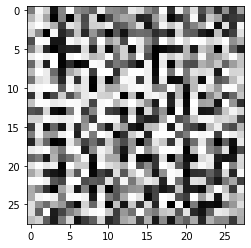

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20)
G.train()

input_z = torch.randn(2, 20)  # BatchNorm이 있기 때문에 2 이상으로 설정해야 함

fake_images = G(input_z)  # torch.Size([2, 1, 28, 28])
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

### Discriminator

이미지와 입력 노이즈의 pair를 입력으로 받음

두 입력은 각각 합성곱, FC 층에서 독립적으로 처리뒨 후 결합, 결합된 텐서는 FC 층을 거쳐 최종 판정 결과 출력

In [19]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()
        
        # 이미지 입력 처리
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))
        
        # 노이즈 입력 처리
        self.z_layer1 = nn.Linear(z_dim, 512)
        
        # 최종 판정 (결합된 입력 처리)
        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True))

        self.last2 = nn.Linear(1024, 1)

    def forward(self, x, z):
        
        # 이미지 입력 처리
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)  # (N, 64, 7, 7)
        x_out = x_out.view(-1, 64 * 7 * 7)  # (N, 3136)
   
        # 노이즈 입력 처리
        z = z.view(z.shape[0], -1)  # (N, 20)
        z_out = self.z_layer1(z)  # (N, 512)

        # 최종 판정
        out = torch.cat([x_out, z_out], dim=1)  # Concat (N, 3648), 3648=3136+512
        out = self.last1(out)  # (N, 1024)

        # AnoGAN과 마찬가지로 최종 출력 이전 층의 feature를 별도로 사용
        feature = out
        feature = feature.view(feature.size()[0], -1)  # (N, 1024)

        out = self.last2(out)

        return out, feature

In [20]:
D = Discriminator(z_dim=20)

input_z = torch.randn(2, 20)
fake_images = G(input_z)

d_out, _ = D(fake_images, input_z)

print(nn.Sigmoid()(d_out))  # 0 ~ 1

tensor([[0.4322],
        [0.4629]], grad_fn=<SigmoidBackward0>)


### Encoder

이미지를 노이즈 z로 변환

판별자와 비슷한 형태. 출력 차원=z_dim

In [21]:
class Encoder(nn.Module):

    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.last = nn.Linear(128 * 7 * 7, z_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = out.view(-1, 128 * 7 * 7)
        out = self.last(out)

        return out

In [22]:
E = Encoder(z_dim=20)

x = fake_images  # 생성자로 생성한 가짜 이미지 (input_z를 입력으로 받음)

# Image to Noise mapping
z = E(x)

print(z.shape)
print(z)

torch.Size([2, 20])
tensor([[-0.0669, -0.2844, -0.3601,  0.1404, -0.2922, -0.4834, -0.0025,  0.0258,
         -0.1298, -0.2613, -0.4292, -0.2584, -0.6141, -0.1440,  0.1142,  0.2175,
          0.0730,  0.0323, -0.7176, -0.7410],
        [ 0.4822,  0.3681, -0.0647, -0.0773,  0.0989,  0.3012,  0.8054,  0.4399,
          1.0848, -0.2809,  0.0619, -0.3179, -0.2963, -0.1192,  0.6562, -0.1707,
          0.1287, -0.6156,  0.3127, -0.4819]], grad_fn=<AddmmBackward0>)


In [23]:
input_z

tensor([[ 0.1554, -1.0886,  1.6625, -0.2912,  0.5645, -0.2161,  0.4823,  0.2058,
          0.1170, -0.9420, -2.7554, -0.1196, -0.2979,  1.2070, -0.4066,  0.1869,
         -0.4447, -1.9914,  0.8704, -0.4112],
        [-0.4780, -0.0311,  0.3894, -0.3777, -0.8123,  2.0157,  1.3826, -0.4303,
          2.0753,  0.6294,  0.8359, -1.4538,  0.2111,  0.2027,  0.8474, -0.2811,
         -0.7316, -0.6328, -0.8258,  0.0790]])

### DataLoader

In [24]:
def make_datapath_list():

    train_img_list = list()  

    for img_idx in range(200):
        img_path = "./data/img_78_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])

    def __call__(self, img):
        return self.data_transform(img)

# Dataset
class GAN_Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        img_path = self.file_list[index]
        img = Image.open(img_path)  

        img_transformed = self.transform(img)

        return img_transformed

In [25]:
train_img_list = make_datapath_list()

mean = (0.5, )
std = (0.5, )
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoader 
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 동작 확인
batch_iterator = iter(train_dataloader)  # 반복자 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(imges.size())  # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 28, 28])


### Train

판별자를 학습시킨 후, 생성자와 인코더를 학습 (인코더가 추가된 것 외에는 일반적인 GAN 학습과 동일함)

판별자는 이미지와 노이즈 쌍을 입력으로 받아 진위 여부를 식별하기 때문에 이미지만 있는 경우보다 식별하기 쉬운 상태

-> 생성자, 인코더보다 학습률을 낮게 설정

In [26]:
def train_model(G, D, E, dataloader, num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    lr_ge = 0.0001
    lr_d = 0.0001 / 4  # 판별자 학습률을 상대적으로 낮게 설정
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # Loss function
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    z_dim = 20
    mini_batch_size = 64

    G.to(device)
    E.to(device)
    D.to(device)

    G.train()  
    E.train()  
    D.train()  

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0 
        epoch_e_loss = 0.0 
        epoch_d_loss = 0.0  

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        for imges in dataloader:

            if imges.size()[0] == 1:
                continue

            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            imges = imges.to(device)

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            # 진짜 이미지 판정
            z_out_real = E(imges)  # E(x)
            d_out_real, _ = D(imges, z_out_real)  # D(x, E(x))

            # 가짜 이미지 생성 & 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)  # z
            fake_images = G(input_z)  # G(z)
            d_out_fake, _ = D(fake_images, input_z)  # D(G(z), z)

            # loss (https://github.com/YutaroOgawa/pytorch_advanced/issues/144)
            label_real = label_real.type_as(d_out_real.view(-1))
            d_loss_real = criterion(d_out_real.view(-1), label_real)  # D(x, E(x))를 진짜라고 판별하도록 학습

            label_fake = label_real.type_as(d_out_fake.view(-1))
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)  # D(G(z), z)를 가짜라고 판별하도록 학습

            d_loss = d_loss_real + d_loss_fake

            # 역전파
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 이미지 생성 & 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)  # z
            fake_images = G(input_z)  # G(z)
            d_out_fake, _ = D(fake_images, input_z)  # D(G(z), z)

            # loss
            g_loss = criterion(d_out_fake.view(-1), label_real)  # D(G(z), z)를 진짜라고 판별하도록 학습 (판별자를 속이도록) 

            # 역전파
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. Encoder 학습
            # --------------------
            # 지도(학습용) 이미지로부터 노이즈 z 추정
            z_out_real = E(imges)  # E(x)
            d_out_real, _ = D(imges, z_out_real)  # D(x, E(x))

            # loss
            e_loss = criterion(d_out_real.view(-1), label_fake)  # (x, E(x))를 가짜((G(z), z))라고 판정하도록 학습
                                                                 # 판별자가 (x, E(x))와 (G(z), z)를 제대로 판정하지 못하도록 학습
            # 역전파
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # --------------------
            # 4. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("총 반복 횟수: ", iteration)

    return G, D, E

In [27]:
# 네트워크 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
    elif classname.find('Linear') != -1:
        m.bias.data.fill_(0)


# Init
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")

네트워크 초기화 완료


In [ ]:
num_epochs = 1500  # 1500 권장
G_update, D_update, E_update = train_model(G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)

# eval
G_update.eval()
fake_images = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다

# 상단 : 학습용 실제 / 하단 : 생성된 가찌 이미지
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

### 테스트 데이터를 사용하여 이상 탐지

In [ ]:
def make_test_datapath_list():

    train_img_list = list()  

    for img_idx in range(5):
        img_path = "./data/test_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

test_img_list = make_test_datapath_list()

# Dataset 
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoader
batch_size = 5
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
batch_iterator = iter(test_dataloader)  
imges = next(batch_iterator)  

# 테스트 데이터 확인 (정상 : 7, 8 / 이상치 : 2)
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

아래의 Anomaly score는 AnoGAN과 동일하나 입력이 조금 다름 (BiGAN의 형태로 판별자 사용)

In [ ]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):  # 노이즈 추가
    
    # 테스트 이미지 x, 생성된 이미지 간의 픽셀 별 차이의 절댓값 계산 & minibatch마다 합 계산
    residual_loss = torch.abs(x - fake_img)  # (N, 1, 28, 28)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)  # (N, 784)
    residual_loss = torch.sum(residual_loss, dim=1)  # (N, )

    # 테스트 이미지, 생성된 이미지를 D에 입력하여 feature 출력
    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)

    # 테스트 이미지의 feature, 생성된 이미지의 feature 간의 픽셀 별 차이의 절댓값 계산 & minibatch마다 합 계산
    discrimination_loss = torch.abs(x_feature - G_feature)  # (N, 1024)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)  # (N, 1024)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)  # (N, )

    # Total loss
    loss_each = (1 - Lambda) * residual_loss + Lambda * discrimination_loss  # minibatch마다 위의 2 종류의 손실을 더함
    total_loss = torch.sum(loss_each)  # 모든 minibatch의 손실 계산

    return total_loss, loss_each, residual_loss

In [ ]:
x = imges[0:5]  # 이상 탐지용
x = x.to(device)

# 테스트용 지도 이미지를 z로 변환(encoding) & 학습된 생성자를 이용하여 생성
E_update.eval()
G_update.eval()
z_out_real = E_update(imges.to(device))  # E(x)=z (테스트 이미지를 인코더에 입력하여 생성 노이즈 z를 출력)
imges_reconstract = G_update(z_out_real)  # G(E(x))=G(z) (테스트 이미지들을 가장 그럴듯 하게 생성하는 노이즈를 이용하여 가짜 이미지 생성)

# loss
loss, loss_each, residual_loss_each = Anomaly_score(x, imges_reconstract, z_out_real, D_update, Lambda=0.1)
loss_each = loss_each.cpu().detach().numpy()
print("total loss: ", np.round(loss_each, 0))

# 확인 (상단 : 이상 탐지용 이미지 / 하단 : 생성된 이미지)
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(), 'gray')

테스트 이미지들을 가장 그럴듯하게 복원할 수 있는 생성 노이즈를 활용했음에도 불구하고 학습용 지도 데이터에 없는 이상치 2 이미지는 제대로 생성하지 못하는 것을 확인.


결과 참고 : https://github.com/YutaroOgawa/pytorch_advanced/blob/master/6_gan_anomaly_detection/6_4_EfficientGAN_GoogleClab.ipynb